In [20]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#NB
from sklearn.pipeline import make_pipeline


# Files
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import email
import email.parser
from email.parser import Parser

#NLP
import nltk
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
def get_cwd():
    try:
        chdir(dirname(realpath(__file__)))
    except:
        chdir('/Users/fabiosavorgnan/Desktop/QTW/Week_1/Data/MSDS-7333-QTW')

    active_dir = getcwd()
       
    return active_dir

def main():
    
    get_cwd()
    
    directories = [
            'easy_ham',
            'easy_ham_2',
            'hard_ham',
            'spam',
            'spam_2'
            ] 
    
    res_frame = pd.DataFrame()

    # *dc - Added to keep a collection of email text
    emails = []

    tmp = []
        
    for d in directories:
        mypath = getcwd() + '/data/' + d + '/'
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
        try:
            onlyfiles.remove('.DS_Store')
        except:
            pass
        
        for file in onlyfiles:
            with open(mypath + file, encoding='latin1') as f:
                lines = f.readlines()
                f.close()
            
            with open(mypath + file, encoding='latin1') as f:
                body = f.read()
                f.close()
                
            msg = email.message_from_string(str(body))
            tmpStr = ''
            
            if msg.is_multipart():
                for payload in msg.get_payload():
                    #tmp.append(str(payload.get_payload()))
                    
                    tmpStr = ' '.join(str(payload.get_payload()))
                tmp.append(tmpStr)
            else:
                tmp.append(str(msg.get_payload()))
                
            in_reply_count = 0
            sub_line_all_caps = 0
            attachments = 0
            subject_line = []
            n_lines = 0
            blank_lines = []
            
            for line in lines:

                n_lines += 1
                if "Subject: Re: " in line:
                   in_reply_count += 1
                if "Subject: " in line:
                   s_line = line.strip().replace('Subject: ','')
                   s_line = ''.join(e for e in s_line if e.isalnum())
                   num_upper = sum(1 for c in s_line if c.isupper())
                   ttl_chars = len(s_line)
                   if num_upper == ttl_chars:
                       sub_line_all_caps += 1
                   subject_line.append(s_line)
                if "content-type: multipart" in line.lower():
                   attachments += 1
                if line == "\n":
                   blank_lines.append(n_lines)
        
            temp_frame = pd.DataFrame({
                        'directory':d,    
                        'filename':file,
                        'is_spam':['Y' if 'spam' in d else 'N'],
                        'in_reply': ['Y' if in_reply_count > 0 else 'N'], 
                        'subj_caps': ['Y' if sub_line_all_caps > 0 else 'N'], 
                        'attachments': ['Y' if attachments > 0 else 'N'],
                        ## *dc+3 
                        #'body_lines': n_lines - min(blank_lines)
                        'body_lines': [0 if len(blank_lines) == 0 else min(blank_lines)]
                        }, index=[0])
           
            res_frame = res_frame.append(temp_frame, ignore_index=True)

            ## *dc+2
            #append body of email to collection
            text = ' '.join(lines)
            emails.append(text)
            
    #res_frame.to_csv('output_file.csv', index=False)
    
    ## *dc - add emails
    return res_frame,   emails, tmp

df,   emails, tmp = main()

In [3]:
 ########################################
     ##### Main Function
 ########################################   
  
print(len(df),len(tmp), len(emails))
print(tmp[0])
 

9353 9353 9353
URL: http://www.newsisfree.com/click/-1,8381145,215/
Date: 2002-09-30T03:04:58+01:00

*Arts:* Fourth art raid on philanthropist's home once targeted by the IRA and 
Dublin gangster Martin Cahill.





# Set up the data to cluster the body of the email

In [4]:

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lowercase and remove special characters to form a normalized document
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()

    # tokenize document
    tokens = nltk.word_tokenize(doc)
    
    # filter out stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Remove numbers
    filtered_tokens = [token for token in filtered_tokens if not token.isdigit()]

    # Remove short tokens
    filtered_tokens = [token for token in filtered_tokens if len(token) > 2]

    # stem tokens - Skipping for now
    #filtered_tokens = [stemming.stem(token) for token in filtered_tokens]

    # re-create a normalized document
    doc = ' '.join(filtered_tokens)
    return doc

normalize_text = np.vectorize(normalize_document)
norm_text = normalize_text(tmp)

print(type(norm_text),len(norm_text))

<class 'numpy.ndarray'> 9353


In [5]:
tf = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=.8, stop_words=stop_words, norm='l2')
tf_matrix = tf.fit_transform(norm_text)

print(tf_matrix.shape)

(9353, 113747)


In [6]:

cv = CountVectorizer(min_df=0, max_df=1., stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_text)

print(cv_matrix.shape)

(9353, 85476)


In [7]:
print(df.columns)

Index(['directory', 'filename', 'is_spam', 'in_reply', 'subj_caps',
       'attachments', 'body_lines'],
      dtype='object')


In [8]:
# replace all Y/N with 1/0

df = df.replace(['Y','N'],[1,0])

df.sample(5)

,directory,filename,is_spam,in_reply,subj_caps,attachments,body_lines
1631,easy_ham,0794.cf41a55933ae8896b668864d7b57b177,0,1,0,0,54
382,easy_ham,1060.f4a2a100431a65ef190bfdeae5a044b2,0,1,0,0,65
7613,spam,0114.c104ada3a249e1e1846c0cd156a303e9,1,0,0,0,22
2366,easy_ham,00289.759738dc8d12e85d6e26b866faa94337,0,1,0,0,53
165,easy_ham,1076.da788224ea4526c1e8e2a5840c9acf73,0,1,0,0,64


# Cluster

In [9]:

NUM_CLUSTERS = 5
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=10, random_state=42).fit(tf_matrix)
km

df['kmeans_cluster'] = km.labels_

email_clusters = (df[['directory', 'kmeans_cluster']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))  # top 20 movies for each cluster
email_clusters = email_clusters.copy(deep=True)

feature_names = tf.get_feature_names()
topn_features = 50
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

sample_silhouette_values = silhouette_samples(tf_matrix, km.labels_)

# get key features for each cluster
for cluster_num in range(NUM_CLUSTERS):

    cluster_silhouette_values = sample_silhouette_values[km.labels_ == cluster_num]

    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    print('CLUSTER #'+str(cluster_num+1), ":", cluster_silhouette_values.mean())
    print('Cluster Size', cluster_silhouette_values.shape[0])
    print('Key Features:', key_features)
    print('-'*80)

/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CLUSTER #1 : 0.04655946091863279
Cluster Size 5738
Key Features: ['com', 'http', 'www', 'http www', 'exmh', 'use', 'html', 'one', 'org', 'fork', 'like', 'people', 'perl', 'would', 'yahoo', 'get', 'xent com', 'xent', 'email', 'time', 'date', 'com mailman', 'com mailman listinfo', 'free', 'use perl', 'mail', 'net', 'wrote', 'url', 'url http', 'message', 'new', 'said', 'please', 'make', 'exmh users', 'mailman', 'xent com mailman', 'http xent', 'mailman listinfo fork', 'http xent com', 'listinfo fork', 'list', 'mailman listinfo', 'even', 'spam', 'know', 'first', 'subject', 'think']
--------------------------------------------------------------------------------
CLUSTER #2 : 0.07719819684644352
Cluster Size 1004
Key Features: ['font', '3d', 'width', 'size', 'color', 'nbsp', 'face', 'td', 'height', 'font face', 'font font', 'href', 'arial', 'align', 'table', 'border', 'href http', 'center', 'src', 'img', 'font size', 'src http', 'http', 'tr', 'com', 'td tr', 'gif', 'font color', 'img src', '

# Output a quick pivot table to see distribution of clusters vs spam/ham

In [10]:

df.pivot_table(index='kmeans_cluster', columns='is_spam', values='directory', aggfunc='count')

is_spam,0,1
kmeans_cluster,,
0,4230.0,1508.0
1,237.0,767.0
2,583.0,NaN
3,1265.0,60.0
4,639.0,64.0


In [11]:
df['directory'].value_counts()

easy_ham      5052
easy_ham_2    1401
spam_2        1398
spam          1001
hard_ham       501
Name: directory, dtype: int64

In [12]:
df.pivot_table(index='kmeans_cluster', columns='directory', values='filename', aggfunc='count')

directory,easy_ham,easy_ham_2,hard_ham,spam,spam_2
kmeans_cluster,,,,,
0,3338.0,636.0,256.0,673.0,835.0
1,2.0,NaN,235.0,273.0,494.0
2,583.0,NaN,NaN,NaN,NaN
3,938.0,320.0,7.0,6.0,54.0
4,191.0,445.0,3.0,49.0,15.0


# Elbow to find the best k number

In [13]:
scores = []

for k in range(1, 20):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(tf_matrix)
    scores.append(kmeans.inertia_)

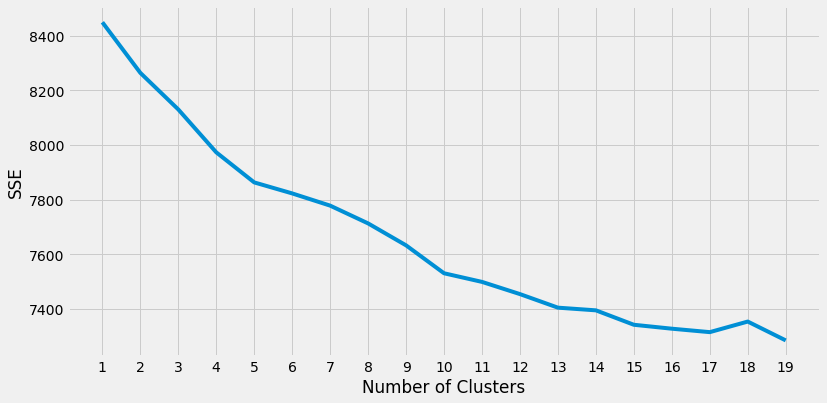

In [14]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,6))
plt.plot(range(1, 20), scores)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# Building the model

In [17]:
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector



categorical_features = ['in_reply','subj_caps','attachments','kmeans_cluster']
numeric_features = ['body_lines']

X = df[categorical_features + numeric_features]
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['classifier', MultinomialNB()]])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.6884019241047569
0.925
0.44803229061553984


# Test without upsampling

In [18]:
clf = MultinomialNB()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.7862105825761625
0.23958333333333334
0.7666666666666667


# Grid search with parameter

In [21]:
categorical_features = ['in_reply','subj_caps','attachments','kmeans_cluster']
numeric_features = ['body_lines']

X = df[categorical_features + numeric_features]
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))]) #,
    #('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['classifier', MultinomialNB()]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

# param_grid = [{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#                'classifier__penalty': ['l1'],
#                'classifier__solver': ['saga']},
#               {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#                'classifier__penalty': ['l2'],
#                'classifier__solver': ['lbfgs']}
#              ]

param_grid = [{'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}]
              
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='precision',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.5058082160938598
Test score: 0.5023474178403756
